# XIA

## Preamplifier: charge to voltage

The electric charge generated in a solid state detector by an incident photon, is integrated by a reset-type preamplifier to produce an output voltage in which the X-ray events are visible as steps. A capacitor discharged is frequently needed and is visible as a jump.
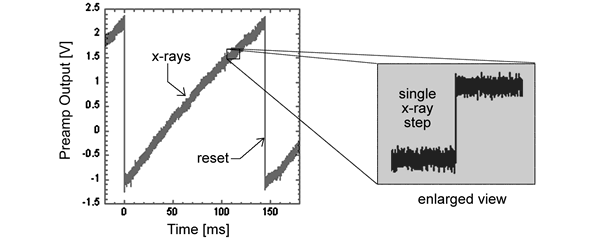

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from spectrocrunch.utils import units

Function that converts X-ray energy to a preamplifier voltage step:

In [39]:
def energytovoltage(energies,noise=True):
    energies = units.Quantity(energies,'keV')
    ehole = units.Quantity(3.8,'eV')
    e = units.Quantity(1,'e')
    ne = (energies/ehole).to('dimensionless').magnitude
    ne = np.asarray(ne)
    # Fano noise (factor=1 which is lower in reality)
    if noise:
        try:
            ne = units.Quantity([np.random.poisson(lam=max(n,0)) for n in ne],'dimensionless')
        except TypeError:
            ne = units.Quantity(np.random.poisson(lam=max(ne,0)),'dimensionless')
    cf = units.Quantity(0.002,'pF')
    return (ne*e/cf).to('V')

def voltagetoenergy(voltage):
    voltage = units.Quantity(voltage,'V')
    ehole = units.Quantity(3.8,'eV')
    cf = units.Quantity(0.002,'pF')
    e = units.Quantity(1,'e')
    energies = voltage*(cf/e*ehole)
    return energies.to('keV')

Function to simulate preamplifier events based on a Poissonian X-ray source with a particular energy spectrum defined by an expected energy and count rate (assume lines have a Lorentzian energy distribution):

In [40]:
def xrays_sample(avgenergies,avgrates,avgtime):
    tunit = 's'
    eunit = 'keV'
    Vunit = 'V'
    hunit = 'Hz'
    
    avgrates = units.Quantity(avgrates,hunit)
    avgtime = units.Quantity(avgtime,tunit)
    events = avgtime*avgrates
    events = events.to('dimensionless').astype(int)

    avgenergies = units.Quantity(avgenergies,eunit)
    energystd = units.Quantity(10,'eV')
    
    emag = lambda x: x.to(eunit).magnitude
    hmag = lambda x: x.to(hunit).magnitude
    vmag = lambda x: x.to(Vunit).magnitude
    ev_time = []
    ev_step = []
    for avgrate,avgenergy,n in zip(avgrates,avgenergies,events):
        # Poisson source
        time_periods = np.random.exponential(scale=1.0/hmag(avgrate), size=n)
        ev_time += time_periods.cumsum().tolist()
        # Lorentzian line
        ev_energy = emag(avgenergy) + np.random.standard_cauchy(size=n)*emag(energystd)
        # Energy to voltage
        ev_volt = energytovoltage(units.Quantity(ev_energy,eunit))
        ev_step += ev_volt.tolist()

    ev_time, ev_step = zip(*sorted(zip(ev_time, ev_step)))
    ev_time = units.Quantity(ev_time,'1/'+hunit).to(tunit)
    ev_step = units.Quantity(ev_step,Vunit)
    
    return ev_time,ev_step

Function to simulate a preamplifier output:

In [41]:
def preamp_sample(ev_time,ev_step,samplefreq):
    samplefreq = units.Quantity(samplefreq,'Hz')
    samplebin = 1./samplefreq
    n = int(np.ceil(((max(ev_time)/samplebin).to('dimensionless').magnitude)))+1
    time = samplebin * np.arange(n)
    
    # Gaussian electronic noise
    estd = units.Quantity(120/(2*np.sqrt(2*np.log(2))),'eV')
    ampstd = energytovoltage(estd,noise=False)
    ampstd = units.Quantity(np.random.normal(scale=ampstd.magnitude,size=n),ampstd.units)
    
    # Preamplifier resets
    ampmax = units.Quantity(3,'V')
    steps = ev_step.cumsum()
    nresets = np.ceil((steps/ampmax).to('dimensionless').magnitude)
    steps -= (nresets.astype(int)-1)*ampmax
    
    # Sample step function
    def pointwise(x):
        ind = np.where(x>=ev_time)[0]
        if ind.size==0:
            return units.quantity_like(0,steps)
        else:
            return steps[ind[-1]]
    ampout = units.asqarray(map(pointwise,time))
    
    return time,ampout,ampstd

Simulate preamplifier output:

In [42]:
avgenergies = units.Quantity([4.,7],'keV')
avgrates = units.Quantity([1.,2],'MHz')
ev_time,ev_step = xrays_sample(avgenergies,avgrates,units.Quantity(300,'us'))
time,ampout,ampstd = preamp_sample(ev_time,ev_step,units.Quantity(50,'MHz'))
signal = ampout+ampstd

Plot preamplifier output histogram (theoretical, i.e. not pulse processed):

Expected:
4.0 keV: 1.0 MHz
7.0 keV: 2.0 MHz
Fitted:
4.00465366106 keV (sigma=135.45719662 eV): 1.00297337643 MHz
6.98645057059 keV (sigma=164.412367131 eV): 1.96546268309 MHz


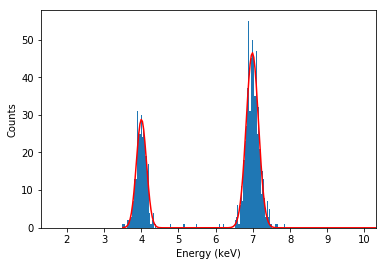

In [43]:
from spectrocrunch.math.distributions import plothistogram
from silx.math.fit.functions import sum_gauss
from silx.math.fit import fittheories
from silx.math.fit.fitmanager import FitManager

#samples = ev_step.to('mV')
samples = voltagetoenergy(ev_step)
y,edges = np.histogram(samples,bins=300)

x = plothistogram(y,edges=edges)
binsize = np.median(np.diff(x))

ax = plt.gca()
xlabel = ax.set_xlabel('Energy ({:~})'.format(samples.units))
ylabel = ax.set_ylabel('Counts')

try:
    samples.to('keV')
    bfit = True
except:
    bfit = False

if bfit:
    fit = FitManager()
    fit.setdata(x=x, y=y)
    fit.loadtheories(fittheories)
    fit.settheory('Gaussians')
    fit.setbackground('No Background')
    fit.estimate()
    fit.runfit()
    yfit = fit.gendata()
    lines = plt.plot(x,yfit,color='r')
    ax = lines[0].axes
    lim = avgenergies.to(samples.units).magnitude
    d = lim[-1]-lim[0]
    ax.set_xlim(lim[0]-0.9*d,lim[-1]+1.1*d)
    
    params = np.array(fit.get_fitted_parameters())
    params = params.reshape((params.size//3,3))
    height,position,FWHM = params.T
    position = units.quantity_like(position,samples)
    area = height*FWHM*np.sqrt(np.pi/(4*np.log(2)))/binsize
    FWHM = units.quantity_like(FWHM,samples)
    sigma = FWHM/(2*np.sqrt(2*np.log(2)))
    rate = area/max(time)
    print('Expected:')
    for e,r in zip(avgenergies.to('keV'),avgrates.to('MHz')):
        print('{:~}: {:~}'.format(e,r))
    print('Fitted:')
    for e,r,s in zip(position.to('keV'),rate.to('MHz'),sigma.to('eV')):
        print('{:~} (sigma={:~}): {:~}'.format(e,s,r))
    

Plot preamplifier output (signal used for pulse processing):

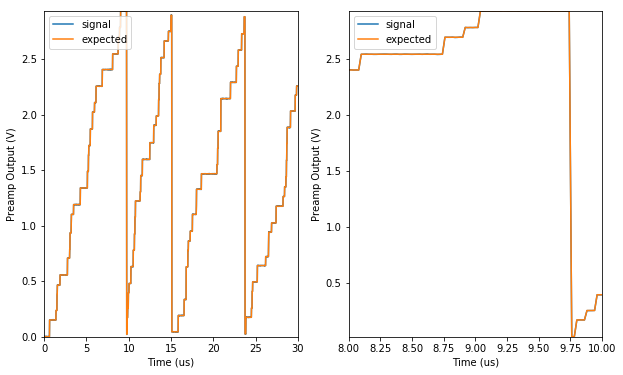

In [44]:
time = time.to('us')
signal = signal.to('V')
ampout = ampout.to('V')

fig,axs = plt.subplots(1,2,figsize=(10,6))

def xlim(ax,xmin,xmax):
    xmin,xmax = units.quantity_like(xmin,time),units.quantity_like(xmax,time)
    tmp = ax.set_xlim(xmin.magnitude,xmax.magnitude)
    visible_y = signal[(xmin < time) & (time < xmax)]
    if len(visible_y):
        tmp = ax.set_ylim(np.min(visible_y).magnitude,
                          np.max(visible_y).magnitude)

def preamp_plot(o,x,y,marker=None,label=None):
    lines = o.plot(x,y,marker=marker,label=label)
    ax = lines[0].axes
    xlabel = ax.set_xlabel('Time ({:~})'.format(x.units))
    ylabel = ax.set_ylabel('Preamp Output ({:~})'.format(y.units))
    return ax

for i in range(2):
    ax = axs[i]
    tmp = preamp_plot(ax,time,signal,label='signal')
    ax.plot(time,ampout,label='expected')
    ax.legend()
    
xlim(axs[0],0,30)
xlim(axs[1],8,10)

## Digital pulse processor

The preamplifier output is filtered by a Trapezoidal filter. This is done twice: fast (X-ray detection, small filter width), slow (energy filter, large filter width). The filter width is given by $2L+G$ where $G$ the gap time and $L$ the peaking time. Peaks are rejected when they are too close together (pile-up). This is done in the fast and slow channel.

 * $ICR_t$: true input count rate
 * $ICR$: measured input count rate after fast channel pile-up rejection. Assuming paralyzable (extending) dead time and a Poisson distributed incoming signal:
    $$
    ICR = ICR_t\exp(-ICR_t\tau_{df})
    $$
    $\tau_{df}$ is the fast channel dead time per event
 * $OCR$: output count rate after fast and slow channel pile-up rejection. Assuming paralyzable (extending) dead time and a Poisson distributed incoming signal:
    $$
    OCR = ICR_t\exp(-ICR_t\tau_d)
    $$
    $\tau_{d}$ is the slow channel dead time per event
    
The XIA records these statistics (not sure what happens to the time of preamplifier resets):

 * $RT$: the actual measurement time
 * $LT_f$: fast channel live time (also called trigger live time). This excludes the time the fast filter signal is above the threshold for peak detection.
 * $N_i$: number of X-rays after fast pile-up rejection
 * $N_o$: number of X-rays after fast and slow pile-up rejection

The input and output count rates can be calculated as follows:
$$ICR=\frac{N_i}{LT_f}$$
$$OCR=\frac{N_o}{RT}$$

The dead time fraction is calculated as follows:
$$DT=\frac{ICR-OCR}{ICR}$$

The live time (also called energy live time) can be calculated as follows:
$$LT=(1-DT)RT=\frac{OCR}{ICR}RT$$
$$DT=\frac{RT-LT}{RT}$$

Dead time correction of MCA:
$$MCA_c=MCA\frac{ICR_t}{OCR}\approx MCA\frac{ICR}{OCR}$$

Filter width: 2 samples, 0.04 us
Filter width: 13 samples, 0.26 us


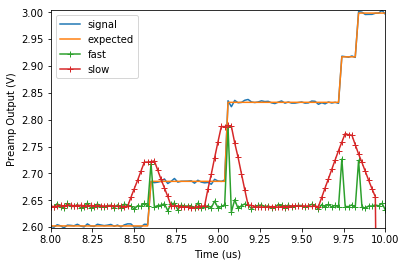

In [18]:
time = time.to('us')
signal = signal.to('V')
ampout = ampout.to('V')

def trapfilter(G,L):
    dt = time[1]-time[0]
    L = max(int(np.ceil(L/dt)),1)
    G = max(int(np.ceil(G/dt)),0)
    print('Filter width: {} samples, {:~}'.format((2*L+G),(2*L+G)*dt))
    return np.concatenate([np.ones(L)/float(L),np.zeros(G),-np.ones(L)/float(L)])

G = units.Quantity(0,'ns')
L = units.Quantity(5,'ns')
wfast = trapfilter(G,L)

G = units.Quantity(0.05,'us')
L = units.Quantity(0.1,'us')
wslow = trapfilter(G,L)

sfast = np.convolve(signal.magnitude,wfast,'same')
sslow = np.convolve(signal.magnitude,wslow,'same')
sfast = units.Quantity(sfast,signal.units)
sslow = units.Quantity(sslow,signal.units)

ax = preamp_plot(plt,time,signal,label='signal')
ax = preamp_plot(plt,time,ampout,label='expected')
xlim(ax,8,10)
ylim = ax.get_ylim()
add = units.quantity_like(ylim[0]+(ylim[1]-ylim[0])*0.1,sfast)
sfast += add
sslow += add
ax = preamp_plot(ax,time,sfast,label='fast',marker='+')
ax = preamp_plot(ax,time,sslow,label='slow',marker='+')
tmp = ax.legend()

## XIA EDF output

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from spectrocrunch.io import xiaedf

path = '/data/id21/store/backup_visitor/2018/ev280/id21/fe2streptor2/fe2streptor2_main_root/zap'
radix = 'fe2streptor2_main_root'
num = 1

xiaimage = xiaedf.xiaimage_number(path,radix,num)
xiaimage.dtcor(False)
xiaimage.detectorsum(False)
xiaimage.counter_reldir('.')

### DXP statistics

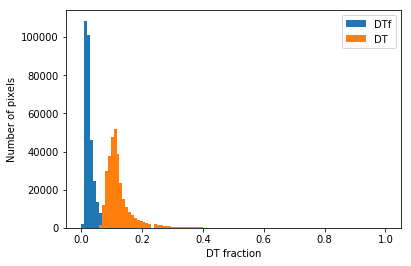

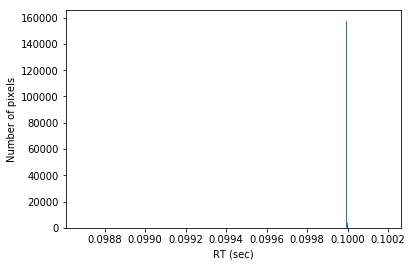

In [3]:
from spectrocrunch.math.distributions import plothistogram

xiaimage.onlyicrocr(False)

stats = xiaimage.stats.astype(float)
EVENTS = stats[...,xiaimage.STEVT,0]
ICR = stats[...,xiaimage.STICR,0]
OCR = stats[...,xiaimage.STOCR,0]
LTf = stats[...,xiaimage.STLT,0]/1000
DT = stats[...,xiaimage.STDT,0]/100

with np.errstate(divide='ignore', invalid='ignore'):
    RT = EVENTS/OCR
    DT2 = (ICR-OCR)/ICR
mask = ICR==0
LTf[mask] = 0.1
RT[mask] = 0.1
DT2[mask] = 1
np.testing.assert_array_almost_equal(DT, DT2, decimal=2) 

with np.errstate(divide='ignore', invalid='ignore'):
    DTf = (RT-LTf)/RT
b = LTf==0
DTf[b] = 1

tmp = plothistogram(*np.histogram(DTf,bins=100),label='DTf')
tmp = plothistogram(*np.histogram(DT,bins=100),label='DT')
ax = plt.gca()
tmp = ax.set_xlabel('DT fraction')
tmp = ax.set_ylabel('Number of pixels')
plt.legend()

plt.figure()
tmp = plothistogram(*np.histogram(RT,bins=1000),label='RT')
ax = plt.gca()
tmp = ax.set_xlabel('RT (sec)')
tmp = ax.set_ylabel('Number of pixels')

### XRF spectra

In [4]:
from spectrocrunch.io import spec
from spectrocrunch.instruments.configuration import factory

xiaimage.dtcor(True)
xiaimage.detectorsum(True)
xiaimage.exclude_detectors(['S0'])
mca = xiaimage.data[...,0]

counters = xiaimage.counterbasenames()
h = xiaimage.header(source=counters[0])
instrument = factory('id21')

speclabel = instrument.edfheaderkeys['speclabel']
kwargs = {'energy':instrument.edfheaderkeys['energylabel']}
parser = spec.edfheader_parser(units=instrument.units,speclabel=speclabel,**kwargs)
info = parser(h)

Sum all channels and detectors:

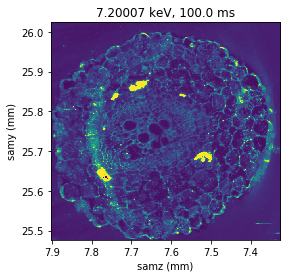

In [5]:
mcasum = mca.sum(axis=-1)
tmp = plt.imshow(mcasum)
ax0,ax1 = info['axes']
title = '{:~}, {:~}'.format(info['energy'],info['time'])

def imshow(ax,image,ax0,ax1,rlo=0,rhi=1,aspect=None):
    d0 = ax0.stepsize
    d1 = ax1.stepsize
    y0 = ax0.start+d0*0.5
    y1 = ax0.end-d0*0.5
    x0 = ax1.start+d1*0.5
    x1 = ax1.end-d1*0.5
    if aspect:
        aspectratio_data = ((y1-y0)/(x1-x0)).to('dimensionless').magnitude
        aspect = aspect/np.abs(aspectratio_data)
    extent = (x0.magnitude,x1.magnitude,y0.magnitude,y1.magnitude)
    mi,ma = np.nanmin(image),np.nanmax(image)
    d = ma-mi
    mi,ma = mi+rlo*d,mi+rhi*d
    image = (image-mi)/(ma-mi)
    image = np.clip(image,0,1)
    img = ax.imshow(image, interpolation = 'nearest',\
               extent = extent, origin = 'lower', aspect = aspect)
    ax = img.axes
    ax.set_xlabel(str(ax0))
    ax.set_ylabel(str(ax1))
    return ax

ax = imshow(plt,mcasum,ax0,ax1,rhi=0.1)
tmp = ax.set_title(title)

Non-Negative Matrix Factorization of all spectra:

In [35]:
from sklearn import decomposition
from numpy.random import RandomState
from scipy.sparse import csr_matrix
from spectrocrunch.utils.timing import timeit

data = mca
nrow,ncol,nchan = mca.shape
nsamples = nrow*ncol
nfeatures = nchan

with timeit('NMF'):
    data = csr_matrix(mca.reshape((nsamples,nfeatures)))
    model = decomposition.NMF(n_components=3, init='random',
                              random_state=RandomState(0))
    coefficients = model.fit_transform(data)

Execution time (NMF): 72.1673099995


Plot components and scores:

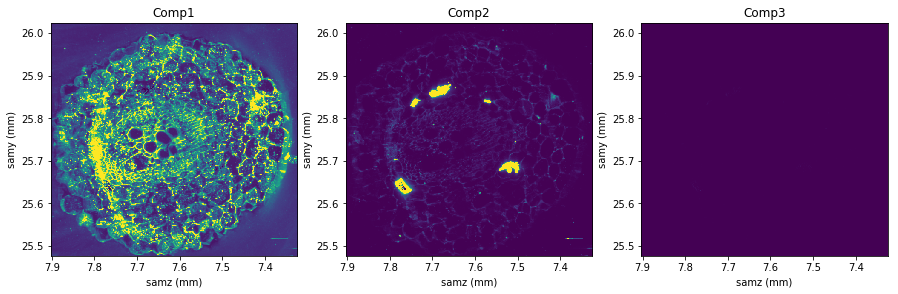

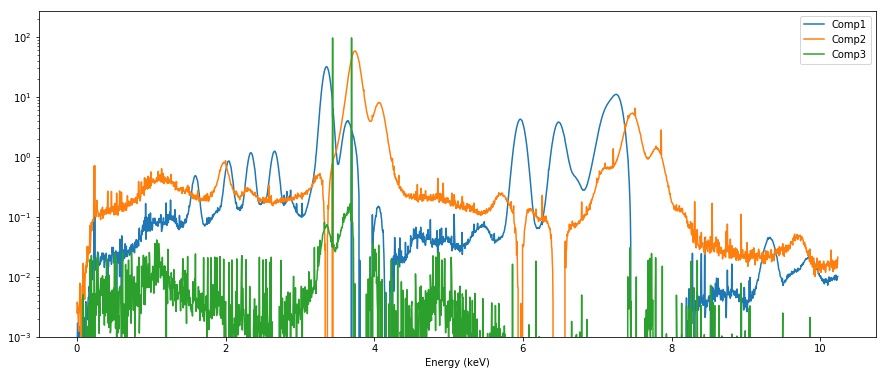

In [36]:
fig,axs = plt.subplots(1,model.n_components,figsize=(15,6))
for i,eigenimage in enumerate(coefficients.T):
    ax = axs[i]
    eigenimage = eigenimage.reshape((nrow,ncol))
    ax = imshow(ax,eigenimage,ax0,ax1,rhi=0.1)
    ax.set_title('Comp{}'.format(i+1))

plt.figure(figsize=(15,6))
mcabin = 5e-3
x = np.arange(nchan)*mcabin
for i,eigenvector in enumerate(model.components_):
    plt.plot(x,eigenvector,label='Comp{}'.format(i+1))
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(0.001,None)
ax.set_xlabel('Energy (keV)')
tmp = ax.legend()